In [13]:
import torch
import torchvision
import torchvision.transforms as transforms

trainset = torchvision.datasets.ImageFolder(
    root="./data/caltech-101",
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Resize((256, 256))]
    ),
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2
)

In [14]:
from cbir import *
from cbir.pipeline import *

rgb_histogram = RGBHistogram(n_bin=8, h_type="region")
resnet = ResNetExtractor(model = "resnet152", pick_layer="avg", device="cuda")
array_store = NPArrayStore(retrieve=KNNRetrieval(metric="euclidean"))

cbir = CBIR(resnet, array_store)

/home/edtechai/miniconda3/envs/yolov10/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
means = np.array([103.939, 116.779, 123.68]) / 255. # mean of three channels in the order of BGR
for images, labels in tqdm(trainloader):
    # print(images.shape)
    # cbir.indexing(images.permute(0, 3, 2, 1).numpy())
    images = images.numpy()
    images = images[:, ::-1, :, :] / 255.
    images[1] -= means[0] 
    images[2] -= means[1] 
    images[3] -= means[2] 
    cbir.indexing(images)

  0%|          | 0/72 [00:00<?, ?it/s]/home/edtechai/miniconda3/envs/yolov10/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/edtechai/miniconda3/envs/yolov10/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResi

In [40]:
img = cv2.imread("/home/edtechai/works/vunt/CV-basic/data/caltech-101/buddha/image_0002.jpg")
img = img[:, :, ::-1]  # switch to BGR
img = np.transpose(img, (2, 0, 1)) / 255.
img[0] -= means[0]  # reduce B's mean
img[1] -= means[1]  # reduce G's mean
img[2] -= means[2]  # reduce R's mean
img = np.expand_dims(img, axis=0)
a = resnet(img)

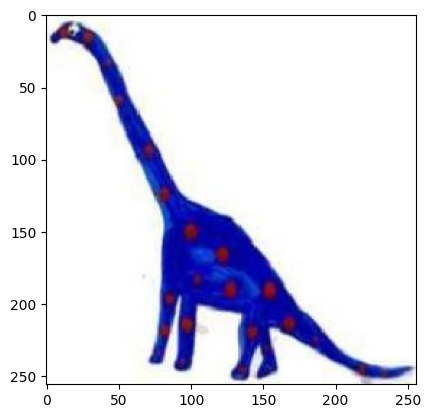

In [44]:
from PIL import Image
import matplotlib.pyplot as plt

plt.imshow(trainset[3696][0].permute(1, 2, 0).numpy())

In [41]:
cbir.feature_store.retrieval.knn.kneighbors(a, n_neighbors=5)

(array([[ 6.48416387, 13.6670097 , 14.02133762, 14.04117315, 14.29241749]]),
 array([[4350, 3696, 3550, 8734,  190]]))

In [26]:
a = resnet(np.expand_dims(cbir.feature_store.images[8789], axis=0))

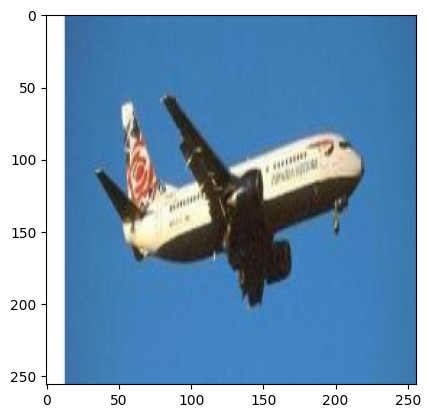

In [19]:
import matplotlib.pyplot as plt

plt.imshow(cbir.feature_store.images[3141].transpose(1, 2, 0))

In [24]:
cbir.feature_store.retrieval.knn = cbir.feature_store.retrieval.knn.fit(cbir.feature_store.X, cbir.feature_store.y)

In [25]:
n1 = cv2.imread("/home/edtechai/works/vunt/CV-basic/data/caltech-101/ant/image_0002.jpg")
torch.tensor(n1).shape
# rs = cbir.retrieve(torch.tensor(n1).unsqueeze(0).permute(0, 3, 1, 2).numpy())
# rs = cbir.retrieve(n1)

torch.Size([200, 300, 3])

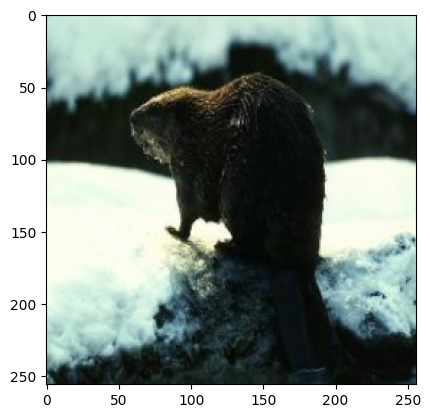

In [72]:
plt.imshow(transforms.Resize((256, 256))(n1).permute(1, 2, 0).numpy())

In [69]:
from PIL import Image
Image.fromarray(n1)

AttributeError: 'Tensor' object has no attribute '__array_interface__'

In [66]:
rs

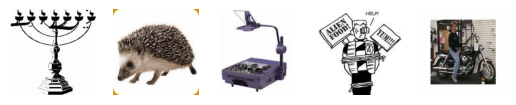

In [65]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,5)
for i, r in enumerate(rs):
    ax[i].imshow(r.image.transpose((1, 2, 0)))
    # ax[i].set_title(f"{r.distance}")
    ax[i].axis("off")
plt.show()

In [16]:
import torchvision.models as models

model = models.resnet152(pretrained=True)

/home/edtechai/miniconda3/envs/cbir/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/edtechai/miniconda3/envs/cbir/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 4.7132e-07,  6.3123e-07,  6.1915e-07,  ...,  2.9313e-07,
                          2.1123e-07,  1.3036e-07],
                        [ 4.8263e-07,  7.1548e-07,  7.1251e-07,  ...,  3.0581e-07,
                          2.6611e-07,  2.3413e-07],
                        [ 4.9888e-07,  6.3326e-07,  6.1920e-07,  ...,  1.2629e-07,
                          1.8429e-07,  2.0732e-07],
                        ...,
                        [ 5.5013e-07,  3.1735e-07,  4.1098e-07,  ...,  3.1079e-07,
                          3.4928e-07,  3.4718e-07],
                        [ 6.2982e-07,  4.0325e-07,  3.4432e-07,  ...,  4.8297e-07,
                          6.4529e-07,  5.4214e-07],
                        [ 7.1402e-07,  5.0883e-07,  4.4785e-07,  ...,  6.2946e-07,
                          6.5617e-07,  5.0979e-07]],
              
                       [[ 5.0878e-07,  6.8802e-07,  6.1782e-07,  ...,  2.2142e-07,
                          2.1541

In [18]:
model(n1)

TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
